<a href="https://colab.research.google.com/github/EziamaUgonna/Bayesian_analysis-/blob/master/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
try:
  # % tensorflow_version only exist in colab
  %tensorflow_version 2.
except Exception:
   pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [77]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import vaex
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
#from tensorflow_probability.python.math import random_rademacher
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import ReLU, Dropout
from tensorflow.keras.optimizers import Adam
# Settings
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
sns.set()
%config InlineBackend.figure_format = 'svg'
from google.colab import files
np.random.seed(12345)
tf.__version__

'2.1.0'

In [78]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
!ls "/content/drive/My Drive/project_data/Bias_sensor1"


Ground_truth_bias_0_1_dur_10_sensor1_dep_train.csv
Ground_truth_bias_0_2_dur_10_sensor1_dep_train.csv
Ground_truth_bias_0_3_dur_10_sensor1_dep_train.csv
Ground_truth_bias_0_4_dur_10_sensor1_dep_train.csv
Ground_truth_bias_0_5_dur_10_sensor1_dep_train.csv
Sensor1_values_bias_0_1_dur_10_dep.csv
Sensor1_values_bias_0_2_dur_10_dep.csv
Sensor1_values_bias_0_3_dur_10_dep.csv
Sensor1_values_bias_0_4_dur_10_dep.csv
Sensor1_values_bias_0_5_dur_10_dep.csv


In [80]:
# Read in the dataset
df1 = pd.read_csv('/content/drive/My Drive/project_data/Bias_sensor1/Sensor1_values_bias_0_1_dur_10_dep.csv').astype(np.float32)
df2 = pd.read_csv('/content/drive/My Drive/project_data/Bias_sensor1/Ground_truth_bias_0_1_dur_10_sensor1_dep_train.csv')
#df1 = pd.read_csv('/content/gdrive/My Drive/Data_package1/Data package/Single Anomaly Types/Bias attack/0_1_dur_10/Sensor1_values_bias_0_1_dur_10_dep.csv').astype(np.float32)
#df1 =  pd.DataFrame(df1)
#df2 = pd.read_csv('/content/gdrive/My Drive/Data_package1/Data package/Single Anomaly Types/Bias attack/0_1_dur_10/Sensor2_values_bias_0_1_dur_10_dep.csv').astype(np.float32)
#df2 =  pd.DataFrame(df2)
#df3 = pd.read_csv('/content/gdrive/My Drive/Data_package1/Data package/Single Anomaly Types/Bias attack/0_1_dur_10/Sensor3_values_bias_0_1_dur_10_dep.csv').astype(np.float32)
#df3 =  pd.DataFrame(df3)
#df = pd.read_csv('/content/gdrive/My Drive/Bsm.13.csv').astype(np.float32)
#df =  pd.DataFrame(df)
#df = pd.read_csv('/content/gdrive/My Drive/Bsm.13.csv').astype(np.float32)
#df =  pd.DataFrame(df)
#df = pd.read_csv('/content/gdrive/My Drive/Bsm.13.csv').astype(np.float32)
#df =  pd.DataFrame(df)
col = df1.columns 
print(col)

Index(['Unnamed: 0', 'RxDevice', 'FileID', 'TxDevice', 'Gentime', 'TxRandom',
       'MsgCount', 'Dsecond', 'Latitude', 'Longitude', 'Elevation', 'Speed',
       'Heading', 'Ax', 'Ay', 'Az', 'Yawrate', 'PathCount', 'RadiusOfCurve',
       'Confidence'],
      dtype='object')


In [0]:
list  = ['Unnamed: 0','RxDevice','FileID']
#df1 = df1.drop(list,axis = 1)

In [0]:
#df.columns = ['RxDevice', 'FileID', 'TxDevice', 'Gentime', 'TxRandom', 'MsgCount',
       #'Dsecond', 'Latitude', 'Longitude', 'Elevation', 'Speed', 'Heading',
       #'Ax', 'Ay', 'Az', 'Yawrate', 'PathCount', 'RadiusOfCurve', 'Confidence']
#dfdata = dfdata.iloc[0:3000,:] 
#dfdata.columns
#df.isnull().values.any() , df.isnull().sum()


In [82]:
"""class Sampling(layers.Layer):
  Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon"""

'class Sampling(layers.Layer):\n  Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.\nclass Sampling(layers.Layer):\n  def call(self, inputs):\n    z_mean, z_log_var = inputs\n    batch = tf.shape(z_mean)[0]\n    dim = tf.shape(z_mean)[1]\n    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))\n    return z_mean + tf.exp(0.5 * z_log_var) * epsilon'

In [0]:
original_dim = 20
intermediate_dim = 32
latent_dim = 32

class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=32,
               intermediate_dim=32,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation = tf.keras.layers.LeakyReLU(alpha=0.05),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01))
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.dense_proj(inputs)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               original_dim,
               intermediate_dim=32,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation = tf.keras.layers.LeakyReLU(alpha=0.05),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01))
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')

  def call(self, inputs):
    x = self.dense_proj(inputs)
    return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,original_dim,intermediate_dim=32,latent_dim=16,name='autoencoder', **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    # Add KL divergence regularization loss.
    kl_loss = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss)
    return reconstructed


vae = VariationalAutoEncoder(original_dim, 32, 32)


In [0]:
X_train_1, X_test_1, y_train, y_test = train_test_split(df1,df2, test_size=0.2, random_state=200)
#X_train_2, X_test_2= train_test_split(df2, test_size=0.2, random_state=200)
#X_train_3, X_test_3= train_test_split(df3, test_size=0.2, random_state=200)
#X_train, X_valid = train_test_split(X_train_full, test_size=0.2, random_state=1)
#X_train_1, X_test_1.shape


In [0]:
# Standardize the dataset 
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1.astype(np.float32))
#X_valid_scaled = scaler.transform(X_valid.astype(np.float32))
X_test_scaled_1 = scaler.transform( X_test_1.astype(np.float32))


#X_train_scaled_2 = scaler.fit_transform(X_train_2.astype(np.float32))
#X_valid_scaled = scaler.transform(X_valid.astype(np.float32))
#X_test_scaled_2 = scaler.transform( X_test_2.astype(np.float32))

#X_train_scaled_3 = scaler.fit_transform(X_train_3.astype(np.float32))
#X_valid_scaled = scaler.transform(X_valid.astype(np.float32))
#X_test_scaled_3 = scaler.transform( X_test_3.astype(np.float32))


In [0]:
#X_train_scaled = tf.data.Dataset.from_tensor_slices(X_train_scaled).shuffle(1000).repeat(3).batch(7)
#X_test_scaled = tf.data.Dataset.from_tensor_slices(X_test_scaled).shuffle(1000).repeat(3).batch(7)


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
vae.compile(optimizer,metrics=['accuracy'], loss = 'mse')
checkpointer1 = ModelCheckpoint(filepath = 'model.weights.best.hdf5', verbose = 2, save_best_only = True)
checkpointer2 = EarlyStopping(monitor ='val_loss', min_delta = 0.0005, patience = 2, verbose =2, mode = 'auto')

In [0]:
n_epoch = 40000

In [88]:
vae_history_1 = vae.fit(X_train_scaled_1, X_train_scaled_1, batch_size= 4, epochs =n_epoch, callbacks = [checkpointer2,checkpointer1], validation_split = 0.25 )

Train on 17999 samples, validate on 6000 samples
Epoch 1/40000
17996/17999 [============================>.] - ETA: 0s - loss: 25.0422 - accuracy: 0.0647
Epoch 00001: val_loss improved from inf to 21.53611, saving model to model.weights.best.hdf5
17999/17999 [==============================] - 13s 741us/sample - loss: 25.0415 - accuracy: 0.0647 - val_loss: 21.5361 - val_accuracy: 0.0608
Epoch 2/40000
17920/17999 [============================>.] - ETA: 0s - loss: 18.3284 - accuracy: 0.0694
Epoch 00002: val_loss improved from 21.53611 to 15.37178, saving model to model.weights.best.hdf5
17999/17999 [==============================] - 13s 701us/sample - loss: 18.3143 - accuracy: 0.0692 - val_loss: 15.3718 - val_accuracy: 0.0657
Epoch 3/40000
17960/17999 [============================>.] - ETA: 0s - loss: 12.7615 - accuracy: 0.0742
Epoch 00003: val_loss improved from 15.37178 to 10.39184, saving model to model.weights.best.hdf5
17999/17999 [==============================] - 13s 709us/sample - 

In [0]:
#vae_history_2 = vae.fit(X_train_scaled_2, X_train_scaled_2, batch_size= 8, epochs =n_epoch, callbacks = [checkpointer2,checkpointer1], validation_split = 0.25 )

In [0]:
#vae_history_3 = vae.fit(X_train_scaled_3, X_train_scaled_3, batch_size= 8, epochs =n_epoch, callbacks = [checkpointer2,checkpointer1], validation_split = 0.25 )

In [91]:
vae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  2784      
_________________________________________________________________
decoder (Decoder)            multiple                  1716      
Total params: 4,500
Trainable params: 4,500
Non-trainable params: 0
_________________________________________________________________


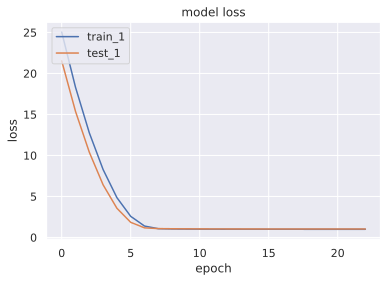

In [92]:
plt.plot(vae_history_1.history['loss'])
plt.plot(vae_history_1.history['val_loss'])
#plt.plot(vae_history_2.history['loss'])
#plt.plot(vae_history_2.history['val_loss'])
#plt.plot(vae_history_3.history['loss'])
#plt.plot(vae_history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_1', 'test_1','train_2', 'test_2','train_3', 'test_3'], loc='upper left')
plt.show();


In [0]:
#Save and Load with TF Model 
#Save TF Model
vae.load_weights("./model.weights.best.hdf5")
predictions = vae.predict(X_test_scaled_1)

In [94]:
mse = np.mean(np.power(X_test_scaled_1-predictions,2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class':y_test})
error_df.describe()

ValueError: ignored

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve,auc, 
                             roc_curve, classification_report, f1_score, precision_recall_fscore_support)


# New Section

In [0]:
"""loss = vae.history.history['loss']
val_loss = vae.history.history['val_loss']
epochs = range(1000)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()"""